**We need GPU with around 12gb RAM to run this Notebook. You can use free GPU P100 available on kaggle or use Colab free GPU.**

# Using Llama v.10

They have done lot of changes in their repo. You can refer to below blog post -

https://blog.llamaindex.ai/llamaindex-v0-10-838e735948f8

# Install Packages

In [1]:
!pip install llama-index llama-index-llms-huggingface llama-index-embeddings-huggingface transformers accelerate bitsandbytes --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires kubernetes<27,>=8.0.0, but you have kubernetes 29.0.0 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you hav

# Downloading data
It's a pdf having current affairs info.

In [2]:
!mkdir -p 'data/'
!wget --user-agent "Mozilla" "https://chahalacademy.com/assets/pdf/Compilation%20of%20Yojana%20And%20Kurukshetra.pdf" -O "data/Yojana.pdf"

--2024-02-22 16:25:13--  https://chahalacademy.com/assets/pdf/Compilation%20of%20Yojana%20And%20Kurukshetra.pdf
Resolving chahalacademy.com (chahalacademy.com)... 103.227.176.27
Connecting to chahalacademy.com (chahalacademy.com)|103.227.176.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32739743 (31M) [application/pdf]
Saving to: 'data/Yojana.pdf'

data/Yojana.pdf     100%[===================>]  31.22M  11.6MB/s    in 2.7s    

2024-02-22 16:25:16 (11.6 MB/s) - 'data/Yojana.pdf' saved [32739743/32739743]



# Import required packages

In [3]:
from pathlib import Path
from llama_index.readers.file import PDFReader,PyMuPDFReader
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.retrievers import RecursiveRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import VectorStoreIndex
from llama_index.core import Document
import json

import torch
from transformers import BitsAndBytesConfig
from llama_index.core.prompts import PromptTemplate
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import IndexNode

# Loading the data

In [4]:
loader = PyMuPDFReader()
docs0 = loader.load_data(file_path=Path("./data/Yojana.pdf"))

doc_text = "\n\n".join([d.get_content() for idx, d in enumerate(docs0) if idx>2])
docs = [Document(text=doc_text)]

# Downloading open source LLM(Zephyr) using HuggingFaceLLM and doing quantization

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)


def messages_to_prompt(messages):
    prompt = ""
    for message in messages:
        if message.role == 'system':
            prompt += f"<|system|>\n{message.content}</s>\n"
        elif message.role == 'user':
            prompt += f"<|user|>\n{message.content}</s>\n"
        elif message.role == 'assistant':
            prompt += f"<|assistant|>\n{message.content}</s>\n"

    # ensure we start with a system prompt, insert blank if needed
    if not prompt.startswith("<|system|>\n"):
        prompt = "<|system|>\n</s>\n" + prompt

    # add final assistant prompt
    prompt = prompt + "<|assistant|>\n"

    return prompt


Settings.llm = HuggingFaceLLM(
    model_name="HuggingFaceH4/zephyr-7b-alpha",
    tokenizer_name="HuggingFaceH4/zephyr-7b-alpha",
    query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={"quantization_config": quantization_config},
    # tokenizer_kwargs={},
    generate_kwargs={"do_sample": False},
    messages_to_prompt=messages_to_prompt,
    device_map="auto",
)

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

# Downloading bge-base embedding model

In [6]:
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# SentenceSplitter
Parse text with a preference for complete sentences.In general, this class tries to keep sentences and paragraphs together.

In [7]:
node_parser = SentenceSplitter(chunk_size=1024,chunk_overlap=0)
base_nodes = node_parser.get_nodes_from_documents(docs)
# set node ids to be a constant
for idx, node in enumerate(base_nodes):
    node.id_ = f"node-{idx}"

# Custom ParentToChildrenNodeParser
 > ### Smaller Child Chunks Referring to Bigger Parent Chunk

In this usage example, we show how to build a graph of smaller chunks pointing to bigger parent chunks.

During query-time, we retrieve smaller chunks, but we follow references to bigger chunks. This allows us to have more context for synthesis.

In [8]:
from typing import Any, Dict, List, Optional, Sequence, Tuple

from llama_index.core.bridge.pydantic import Field
from llama_index.core.callbacks.base import CallbackManager
from llama_index.core.callbacks.schema import CBEventType, EventPayload
from llama_index.core.node_parser.interface import NodeParser
from llama_index.core.node_parser.text.sentence import SentenceSplitter
from llama_index.core.schema import BaseNode, Document, NodeRelationship, IndexNode
from llama_index.core.utils import get_tqdm_iterable

class ParentToChildrenNodeParser(NodeParser):
    """Parent to Child node parser.

    Splits a document into a recursive hierarchy Nodes using a NodeParser.

    NOTE: this will return a hierarchy of nodes in a flat list, where there will be
    overlap between parent nodes (e.g. with a bigger chunk size), and child nodes
    per parent (e.g. with a smaller chunk size).

    For chunk_sizes as [2048, 512, 128]
        - First index value(2048) will be treated as parent node
        - Rest other index values(512,128) will be child nodes pointing directly to parent node(2048)
        using IndexNode.
    """

    chunk_sizes: Optional[List[int]] = Field(
        default=None,
        description=(
            "The chunk sizes to use when splitting documents, in order of level."
        ),
    )
    node_parser_ids: List[str] = Field(
        default_factory=list,
        description=(
            "List of ids for the node parsers to use when splitting documents, "
            + "in order of level (first id used for first level, etc.)."
        ),
    )
    node_parser_map: Dict[str, NodeParser] = Field(
        description="Map of node parser id to node parser.",
    )

    @classmethod
    def from_defaults(
        cls,
        chunk_sizes: Optional[List[int]] = None,
        chunk_overlap: int = 20,
        node_parser_ids: Optional[List[str]] = None,
        node_parser_map: Optional[Dict[str, NodeParser]] = None,
        include_metadata: bool = True,
        include_prev_next_rel: bool = True,
        callback_manager: Optional[CallbackManager] = None,
    ) -> "ParentToChildrenNodeParser":
        callback_manager = callback_manager or CallbackManager([])

        if node_parser_ids is None:
            if chunk_sizes is None:
                chunk_sizes = [2048, 512, 128]

            node_parser_ids = [f"chunk_size_{chunk_size}" for chunk_size in chunk_sizes]
            node_parser_map = {}
            for chunk_size, node_parser_id in zip(chunk_sizes, node_parser_ids):
                node_parser_map[node_parser_id] = SentenceSplitter(
                    chunk_size=chunk_size,
                    callback_manager=callback_manager,
                    chunk_overlap=chunk_overlap,
                    include_metadata=include_metadata,
                    include_prev_next_rel=include_prev_next_rel,
                )
        else:
            if chunk_sizes is not None:
                raise ValueError("Cannot specify both node_parser_ids and chunk_sizes.")
            if node_parser_map is None:
                raise ValueError(
                    "Must specify node_parser_map if using node_parser_ids."
                )

        return cls(
            chunk_sizes=chunk_sizes,
            node_parser_ids=node_parser_ids,
            node_parser_map=node_parser_map,
            include_metadata=include_metadata,
            include_prev_next_rel=include_prev_next_rel,
            callback_manager=callback_manager,
        )

    @classmethod
    def class_name(cls) -> str:
        return "ParentToChildrenNodeParser"

    def _get_nodes_from_doc(
        self,
        docs: List[Document],
        show_progress: bool = False,
    ) -> Tuple[List[BaseNode],Dict[str, BaseNode]]:
        """get nodes from docs."""

        # first split current nodes into sub-nodes
        docs_with_progress = get_tqdm_iterable(
            docs, show_progress, "Parsing documents into nodes"
        )
        base_nodes = []
        for node in docs_with_progress:
            cur_sub_nodes = self.node_parser_map[
                self.node_parser_ids[0]
            ].get_nodes_from_documents([node])
            base_nodes.extend(cur_sub_nodes)
        
        for idx, node in enumerate(base_nodes):
            node.id_ = f"node-{idx}"
        
        nodes_with_progress = get_tqdm_iterable(
            base_nodes, show_progress, "Parsing nodes into sub nodes"
        )
        all_nodes = []
        for node in nodes_with_progress:
            for level in range(len(self.node_parser_ids)):
                if level>0:
                    cur_sub_nodes = self.node_parser_map[
                        self.node_parser_ids[level]
                    ].get_nodes_from_documents([node])
                    sub_inodes = [
                        IndexNode.from_text_node(sn, node.node_id) for sn in cur_sub_nodes
                    ]
                    all_nodes.extend(sub_inodes)
            
        return all_nodes, {n.node_id: n for n in base_nodes}

    def get_nodes_from_documents(
        self,
        documents: Sequence[Document],
        show_progress: bool = False,
        **kwargs: Any,
    ) -> List[BaseNode]:
        """Parse document into nodes.

        Args:
            documents (Sequence[Document]): documents to parse
            include_metadata (bool): whether to include metadata in nodes

        """
        with self.callback_manager.event(
            CBEventType.NODE_PARSING, payload={EventPayload.DOCUMENTS: documents}
        ) as event:
            all_nodes: List[BaseNode] = []
            all_base_nodes_dict: Dict[str, BaseNode] = dict()
            documents_with_progress = get_tqdm_iterable(
                documents, show_progress, "Parsing documents into nodes"
            )
            for doc in documents_with_progress:
                nodes_from_doc,base_nodes_dict = self._get_nodes_from_doc([doc])
                all_nodes.extend(nodes_from_doc)
                all_base_nodes_dict.update(base_nodes_dict)
            event.on_end(payload={EventPayload.NODES: all_nodes})

        return all_nodes, all_base_nodes_dict

    # Unused abstract method
    def _parse_nodes(
        self, nodes: Sequence[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        return list(nodes)

# ParentToSentenceNodeParser

In [9]:
from typing import Any, Dict, List, Optional, Sequence, Tuple

from llama_index.core.bridge.pydantic import Field
from llama_index.core.callbacks.base import CallbackManager
from llama_index.core.callbacks.schema import CBEventType, EventPayload
from llama_index.core.node_parser.interface import NodeParser
from llama_index.core.node_parser.text.sentence import SentenceSplitter
from llama_index.core.schema import BaseNode, Document, NodeRelationship, IndexNode, TextNode
from llama_index.core.utils import get_tqdm_iterable
from llama_index.core.node_parser.text.utils import split_by_sentence_tokenizer

class ParentToSentenceNodeParser(NodeParser):
    """Parent to Sentence node parser.

    Splits a document into a Parent nodes and sentence nodes referring to parent node
    using a NodeParser.
    """

    chunk_size: int = Field(
        default=None,
        description=(
            "The chunk size to use when splitting documents"
        ),
    )
    
    node_parser: SentenceSplitter = Field(
        default=SentenceSplitter,
        description=(
            "The chunk size to use when splitting documents"
        ),
    )

    @classmethod
    def from_defaults(
        cls,
        chunk_size: int = 1024,
        chunk_overlap: int = 20,
        node_parser: SentenceSplitter = None,
        include_metadata: bool = True,
        include_prev_next_rel: bool = True,
        callback_manager: Optional[CallbackManager] = None,
    ) -> "ParentToChildrenNodeParser":
        callback_manager = callback_manager or CallbackManager([])

        
        node_parser = SentenceSplitter(
                    chunk_size=chunk_size,
                    callback_manager=callback_manager,
                    chunk_overlap=chunk_overlap,
                    include_metadata=include_metadata,
                    include_prev_next_rel=include_prev_next_rel,
                    )

        return cls(
            chunk_size=chunk_size,
            node_parser=node_parser,
            include_metadata=include_metadata,
            include_prev_next_rel=include_prev_next_rel,
            callback_manager=callback_manager,
        )

    @classmethod
    def class_name(cls) -> str:
        return "ParentToChildrenNodeParser"

    def _get_nodes_from_doc(
        self,
        docs: List[Document],
        show_progress: bool = False,
    ) -> Tuple[List[BaseNode],Dict[str, BaseNode]]:
        """get nodes from docs."""

        # first split current nodes into sub-nodes
        docs_with_progress = get_tqdm_iterable(
            docs, show_progress, "Parsing documents into nodes"
        )
        base_nodes = []
        for node in docs_with_progress:
            cur_sub_nodes = self.node_parser.get_nodes_from_documents([node])
            base_nodes.extend(cur_sub_nodes)
        
        for idx, node in enumerate(base_nodes):
            node.id_ = f"node-{idx}"
        
        nodes_with_progress = get_tqdm_iterable(
            base_nodes, show_progress, "Parsing nodes into sub nodes"
        )
        sent_node_parser = split_by_sentence_tokenizer()
        all_nodes = []
        for node in nodes_with_progress:
            sub_nodes = sent_node_parser(node.text)
            sub_inodes = [
                IndexNode.from_text_node(TextNode(text=sn), node.node_id) for sn in sub_nodes
            ]
            all_nodes.extend(sub_inodes)
            
        return all_nodes, {n.node_id: n for n in base_nodes}

    def get_nodes_from_documents(
        self,
        documents: Sequence[Document],
        show_progress: bool = False,
        **kwargs: Any,
    ) -> List[BaseNode]:
        """Parse document into nodes.

        Args:
            documents (Sequence[Document]): documents to parse
            include_metadata (bool): whether to include metadata in nodes

        """
        with self.callback_manager.event(
            CBEventType.NODE_PARSING, payload={EventPayload.DOCUMENTS: documents}
        ) as event:
            all_nodes: List[BaseNode] = []
            all_base_nodes_dict: Dict[str, BaseNode] = dict()
            documents_with_progress = get_tqdm_iterable(
                documents, show_progress, "Parsing documents into nodes"
            )
            for doc in documents_with_progress:
                nodes_from_doc,base_nodes_dict = self._get_nodes_from_doc([doc])
                all_nodes.extend(nodes_from_doc)
                all_base_nodes_dict.update(base_nodes_dict)
            event.on_end(payload={EventPayload.NODES: all_nodes})

        return all_nodes, all_base_nodes_dict

    # Unused abstract method
    def _parse_nodes(
        self, nodes: Sequence[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        return list(nodes)

# Evaluation
We evaluate how well our recursive retrieval + node reference methods work. We evaluate both chunk references as well as metadata references. We use embedding similarity lookup to retrieve the reference nodes.

We compare both methods against a baseline retriever where we fetch the raw nodes directly.

In terms of metrics, we evaluate using both hit-rate and MRR.

# Dataset Generation
We first generate a dataset of questions from the set of text chunks.

In [10]:
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
)

import nest_asyncio

nest_asyncio.apply()

**It will take some time to generate the questions.** 
I will also upload the question and context json, in case you want load that instead of running this code.

In [11]:
eval_dataset = generate_question_context_pairs(
    base_nodes, Settings.llm, num_questions_per_chunk=5,
)

In [12]:
eval_dataset.save_json("data/yojana_eval_dataset_qc.json")

In [13]:
try:
    eval_dataset = EmbeddingQAFinetuneDataset.from_json(
        "data/yojana_eval_dataset_qc.json"
    )
except:
    # loading from Kaggle input data
    eval_dataset = EmbeddingQAFinetuneDataset.from_json(
        "../input/rag-data/yojana_eval_dataset_qc.json"
    )

In [14]:
len(list(eval_dataset.queries.keys())),len(base_nodes)

(201, 38)

In [22]:
eval_dataset.query_docid_pairs[:3]

[("What is the significance of the United Nations' declaration of 2023 as the International Year of Millets, and how does India's role in millet production contribute to this declaration?",
  ['node-0']),
 ('Which states in India are the top producers of millets, and what are the average yields of millets in India compared to the global average?',
  ['node-0']),
 ('According to the World Food Programme, how many people consume millets as part of their diet, and what are the estimated production and largest producers of millets globally?',
  ['node-0'])]

# Compare Results

We run evaluations on each of the retrievers to measure hit rate and MRR.

**Hit rate** - The hit rate is a binary score indicating the presence of the correct chunk in the retrieved chunks. Score of 1 means are all correct chunk is present in retrieved chunks.

**Mean Reciprocal Ranking (MRR)** -  is a metric used to evaluate the effectiveness of search engines, recommendation systems, or any system that involves ranking a list of items. It's particularly common in information retrieval.

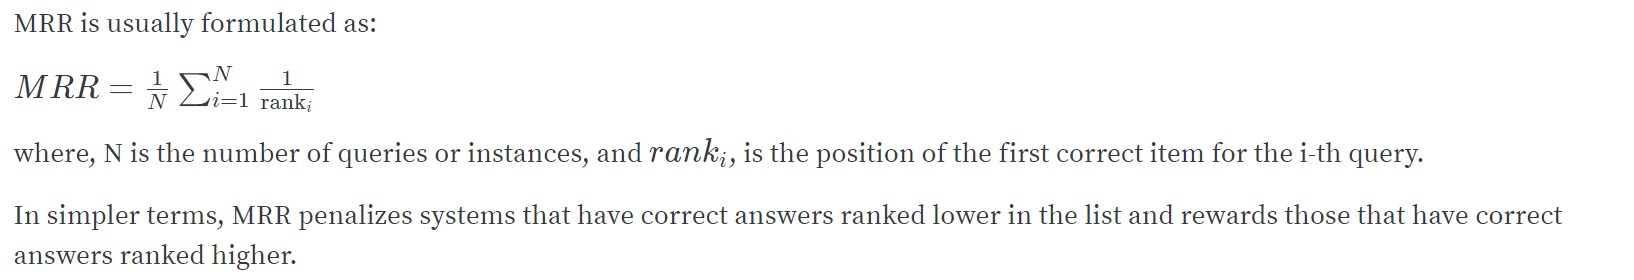

In [15]:
import pandas as pd
from llama_index.core.evaluation import (
    RetrieverEvaluator,
    get_retrieval_results_df,
)

# set vector retriever similarity top k to higher
top_k = 3


def display_results(names, results_arr):
    """Display results from evaluate."""

    hit_rates = []
    mrrs = []
    for name, eval_results in zip(names, results_arr):
        metric_dicts = []
        for eval_result in eval_results:
            metric_dict = eval_result.metric_vals_dict
            metric_dicts.append(metric_dict)
        results_df = pd.DataFrame(metric_dicts)

        hit_rate = results_df["hit_rate"].mean()
        mrr = results_df["mrr"].mean()
        hit_rates.append(hit_rate)
        mrrs.append(mrr)

    final_df = pd.DataFrame(
        {"retrievers": names, "hit_rate": hit_rates, "mrr": mrrs}
    )
    display(final_df)

# Base Retriever Evaluation

In [16]:
base_index = VectorStoreIndex(base_nodes)
base_retriever = base_index.as_retriever(similarity_top_k=top_k)
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=base_retriever
)
# try it out on an entire dataset
results_base = await retriever_evaluator.aevaluate_dataset(
    eval_dataset, show_progress=True
)

100%|██████████| 201/201 [00:03<00:00, 65.51it/s]


# ParentToChildrenNodeParser

In [17]:
p2c_node_parser = ParentToChildrenNodeParser.from_defaults([1024,512,256], chunk_overlap=0)
all_nodes,all_base_nodes_dict = p2c_node_parser.get_nodes_from_documents(docs)
vector_index_chunk = VectorStoreIndex(all_nodes)
vector_retriever_chunk = vector_index_chunk.as_retriever(similarity_top_k=top_k)
retriever_chunk_p2c = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk},
    node_dict=all_base_nodes_dict,
    verbose=False,
)
retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever_chunk_p2c
)
# try it out on an entire dataset
results_chunk_p2c = await retriever_evaluator.aevaluate_dataset(
    eval_dataset, show_progress=True
)

100%|██████████| 201/201 [00:04<00:00, 41.66it/s]


# ParentToSentenceNodeParser

In [18]:
p2s_node_parser = ParentToSentenceNodeParser.from_defaults(chunk_size=1024, chunk_overlap=0)
all_nodes_sent,all_base_nodes_dict_sent = p2s_node_parser.get_nodes_from_documents(docs)
vector_index_chunk_sent = VectorStoreIndex(all_nodes_sent)
vector_retriever_chunk_sent = vector_index_chunk_sent.as_retriever(similarity_top_k=top_k)
retriever_chunk_sent = RecursiveRetriever(
    "vector",
    retriever_dict={"vector": vector_retriever_chunk_sent},
    node_dict=all_base_nodes_dict_sent,
    verbose=False,
)

retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever_chunk_sent
)
# try it out on an entire dataset
results_chunk_sent = await retriever_evaluator.aevaluate_dataset(
    eval_dataset, show_progress=True
)

100%|██████████| 201/201 [00:11<00:00, 17.03it/s]


# Hit Rate and MRR with top_k as 3

In [19]:
full_results_df = get_retrieval_results_df(
    [
        "Base Retriever",
        "Retriever (ParentToChildrenNodeParser)",
        "Retriever (ParentToSentenceNodeParser)",
    ],
    [results_base, results_chunk_p2c, results_chunk_sent],
)
display(full_results_df)

,retrievers,hit_rate,mrr
0,Base Retriever,0.910448,0.818408
1,Retriever (ParentToChildrenNodeParser),0.930348,0.883914
2,Retriever (ParentToSentenceNodeParser),0.975124,0.932836
